<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/part10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Head Attention

The term "multi-head" refers to dividing the attention mechanism into multiple heads. (each operating independently)

- stacking multiple single head attention layers.
- Implementing multi-head attention involves creating multiple instances of the self-attention mechanism; each with it's own weights, and then combining their outputs.

This can be computationally intensive, but it makes LLMs powerful at complex patten recognition tasks.

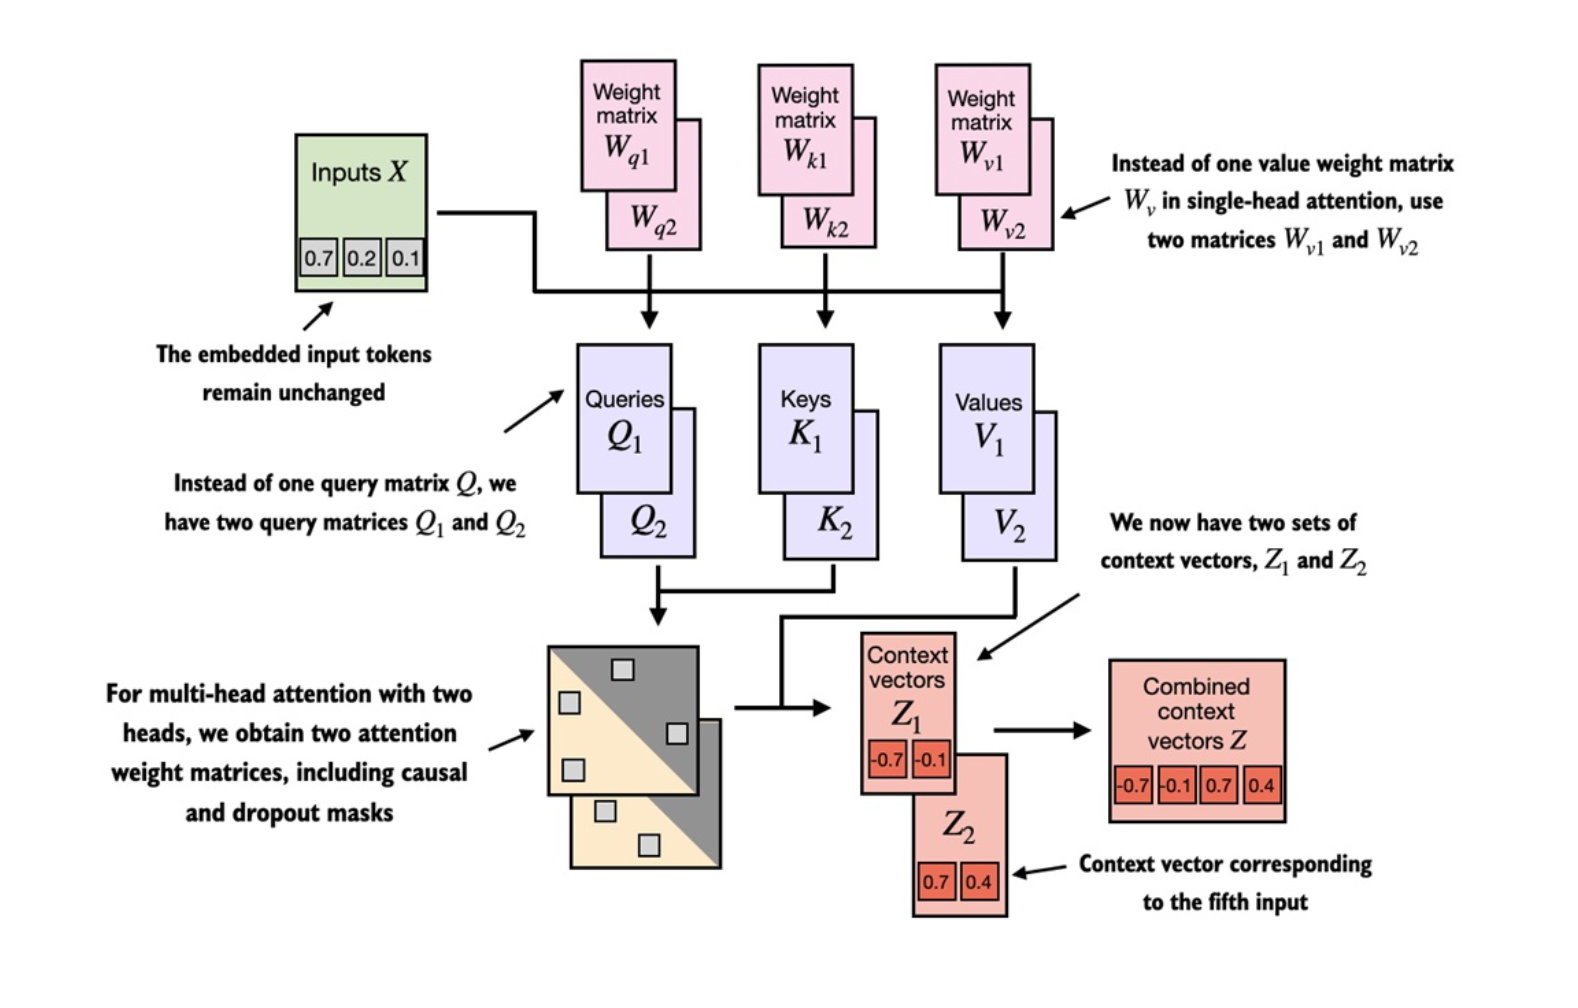

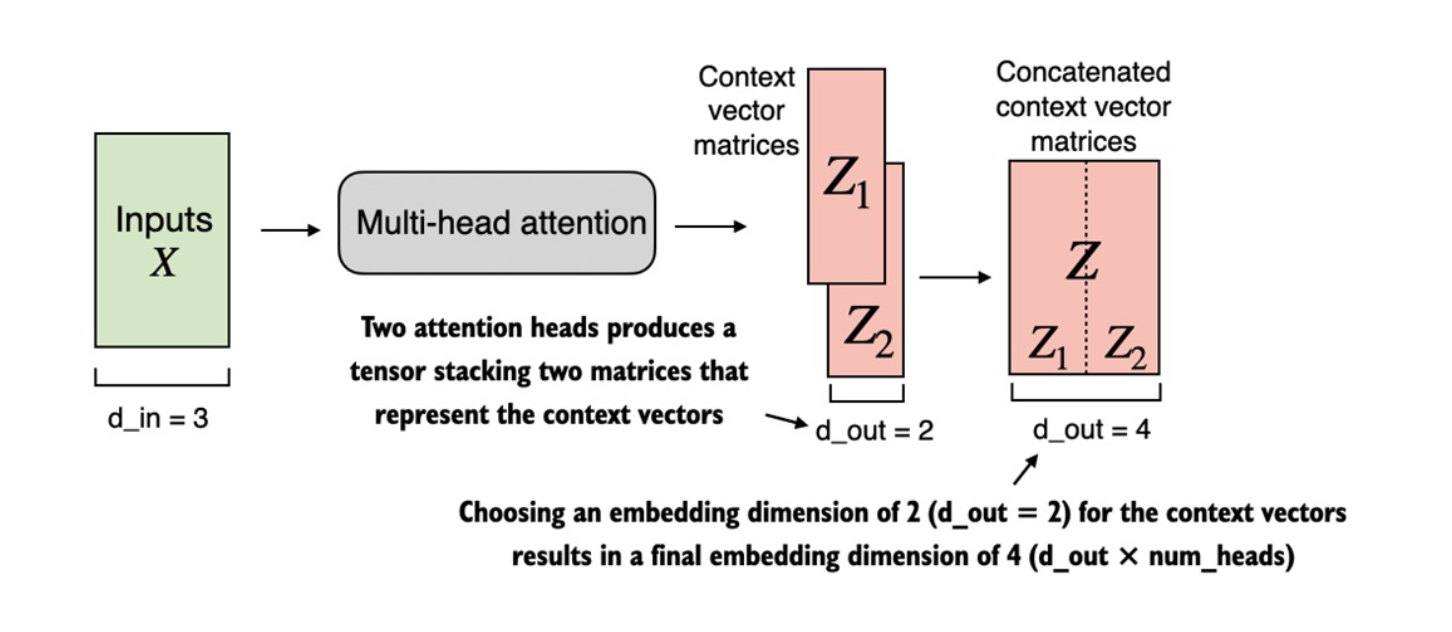

Main idea - Run the attention mechanism multiple times(in parallel) with different, learned linear projection the results of multiplying input data.

In [2]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [3]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [4]:
import torch.nn as nn

class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
      b, num_tokens, d_in = x.shape
      keys = self.W_key(x)
      queries = self.W_query(x)
      values = self.W_value(x)

      attn_scores = queries @ keys.transpose(1, 2) # only interested in num_tokens and d_in so that's why pass index 1 and 2

      attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size

      attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
      context_vec = attn_weights @ values

      return context_vec


In [5]:
d_in = inputs.shape[1]
d_out = 2

In [6]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In practical terms, implementing multi-head attention involves creating multiple instances
of the self-attention mechanism, each with
its own weights, and then combining their outputs.

In code, we can achieve this by implementing a simple MultiHeadAttentionWrapper class that stacks multiple instances of our previously implemented CausalAttention module:

In [7]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


In [8]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


In this section, we implemented a MultiHeadAttentionWrapper that combined multiple single-head attention modules.

However, note that these are processed sequentially via
[head(x) for head in self.heads] in the forward method.

We can improve this implementation by processing the heads in parallel.

One way to achieve this is by computing the outputs for all attention heads simultaneously via matrix multiplication, as we will explore in the next section.

Main problem with this approach is that, here we need 2 matrix multiplication calculation is needed.

GPT3 uses 96 attention heads. We need 96 multiplication calculation is need to get context vectors.

This is not efficient. How can we make sure calculation is less?

One way to achieve this is by computing the outputs for all
attention heads simultaneously via matrix multiplication.

## Implementing multi-head attention with weight splits

- Instead of maintaining 2 separate class MultiHeadAttentionWrapper and Causal Attention, we comined both of these into a single MultiHeadAttention class.

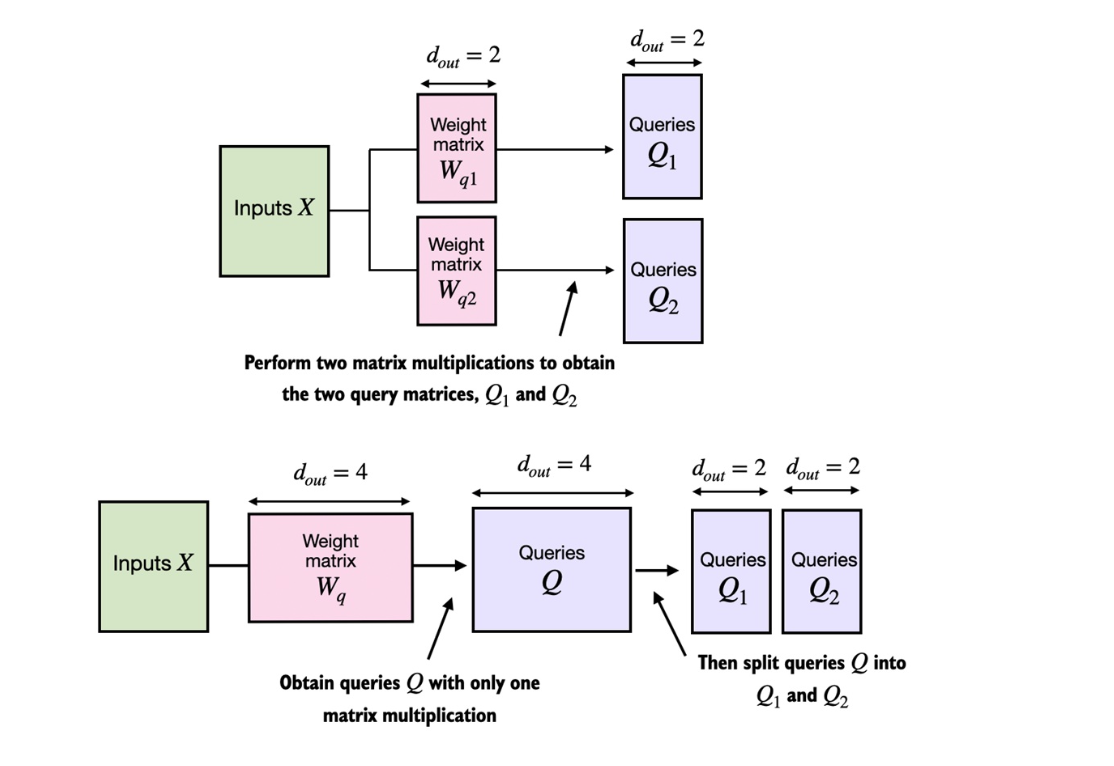

head_dim = d_out / num_heads


In [9]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
      super().__init__()
      assert (d_out % num_heads == 0), \
          "d_out must be divisible by num_heads"

      self.d_out = d_out
      self.num_heads = num_heads
      self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

      self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
      self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
      self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
      self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
      self.dropout = nn.Dropout(dropout)
      self.register_buffer(
          "mask",
          torch.triu(torch.ones(context_length, context_length),
                    diagonal=1)
      )

  def forward(self, x):
      b, num_tokens, d_in = x.shape # x -> 1x3x6 for batch 1
      keys = self.W_key(x) # W_key = 6x6 -> keys = input(1x3x6) * keys(6x6) = 1x3x6 same for queries and values.
      queries = self.W_query(x)
      values = self.W_value(x)

      # keys, queries, values shape (b, num_tokens, d_out)
      # unroll last dimension of keys, queries, and values to include num_heads and head_dim.
      # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim) = (1,3,6) -> (1,3,2,3)
      keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
      values = values.view(b, num_tokens, self.num_heads, self.head_dim)
      queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

      # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim) (1,2,3,3)
      keys = keys.transpose(1, 2)
      queries = queries.transpose(1, 2)
      values = values.transpose(1, 2)

      # Compute scaled dot-product attention (aka self-attention) with a causal mask
      # keys - (1,2,3,3) and  queries- (1,2,3,3) -> k.T = (1,2,3,3)
      # attn_score = (1,2,3,3) @ (1,2,3,3) ->
      # queries = (b, num_heads, num_tokens, head_dim) , keys.T = (b, num_heads, head_dim, num_tokens)
      # attn_score = (b, num_heads, num_tokens, num_tokens) = (1, 2, 3, 3)
      attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

      # Original mask truncated to the number of tokens and converted to boolean
      mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

      # Use the mask to fill attention scores
      attn_scores.masked_fill_(mask_bool, -torch.inf)

      attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
      attn_weights = self.dropout(attn_weights)

      # attn_weights =  (b, num_heads, num_tokens, num_tokens) (1,2,3,3)
      # values = (b, num_heads, num_tokens, head_dim) (1,2,3,3)
      # final = (b, num_heads, num_toekns, head_dim) - (1,2,3,3) transponse
      # Shape: (b, num_tokens, num_heads, head_dim) - (1,3,2,3)
      context_vec = (attn_weights @ values).transpose(1, 2)

      # Combine heads, where self.d_out = self.num_heads * self.head_dim
      context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
      context_vec = self.out_proj(context_vec) # optional projection

      return context_vec

### 🧩 Tensor Reshaping Example in Multi-Head Attention

#### Given

```
(b, num_tokens, d_out) → (b, num_tokens, num_heads, head_dim)
(1, 3, 6) → (1, 3, 2, 3)
```

#### Parameters

| Symbol       | Meaning                   | Value |
| :----------- | :------------------------ | :---- |
| `b`          | batch size                | 1     |
| `num_tokens` | number of tokens          | 3     |
| `d_out`      | total feature dimension   | 6     |
| `num_heads`  | number of attention heads | 2     |
| `head_dim`   | features per head         | 3     |

---

#### 🔹 Before reshape — shape `(1, 3, 6)`

```python
[
  [  # batch 1
    [1, 2, 3, 4, 5, 6],      # token 1
    [7, 8, 9, 10, 11, 12],   # token 2
    [13, 14, 15, 16, 17, 18] # token 3
  ]
]
```

---

#### 🔹 After reshape — shape `(1, 3, 2, 3)`

Each token’s 6-dimensional vector is split into 2 heads × 3 features:

| Token | Before                     | After reshape (`[num_heads][head_dim]`) |
| :---- | :------------------------- | :-------------------------------------- |
| 1     | `[1, 2, 3, 4, 5, 6]`       | `[[1, 2, 3], [4, 5, 6]]`                |
| 2     | `[7, 8, 9, 10, 11, 12]`    | `[[7, 8, 9], [10, 11, 12]]`             |
| 3     | `[13, 14, 15, 16, 17, 18]` | `[[13, 14, 15], [16, 17, 18]]`          |

Resulting tensor:

```python
[
  [
    [[1, 2, 3], [4, 5, 6]],
    [[7, 8, 9], [10, 11, 12]],
    [[13, 14, 15], [16, 17, 18]]
  ]
]
```

---

#### 🧠 Intuition

* The reshape splits one large feature vector into **multiple smaller “heads.”**
* Each head can learn **different patterns or relationships** in attention.
* All heads are later combined again to form the final output.

### 🔄 Transpose in Multi-Head Attention

#### 📐 Before Transpose

Shape:

```
(b, num_tokens, num_heads, head_dim)
```

Example from before:

```
(1, 3, 2, 3)
```

Meaning:

* `b = 1` → batch size
* `num_tokens = 3` → number of tokens
* `num_heads = 2` → number of attention heads
* `head_dim = 3` → feature dimensions per head

Each batch currently stores **tokens first**, then **heads**.

---

#### 🔁 After Transpose

Shape:

```
(b, num_heads, num_tokens, head_dim)
```

→ Example: `(1, 2, 3, 3)`

Now each batch stores **heads first**, then **tokens**.

---

#### 📊 Visualization

Before (`(1, 3, 2, 3)`):

```
[
  [
    [[1,2,3], [4,5,6]],   # token 1: head1, head2
    [[7,8,9], [10,11,12]],# token 2: head1, head2
    [[13,14,15],[16,17,18]]# token 3: head1, head2
  ]
]
```

After transpose (`(1, 2, 3, 3)`):

```
[
  [ # head 1
    [[1,2,3], [7,8,9], [13,14,15]],   # 3 tokens for head 1
  ],
  [ # head 2
    [[4,5,6], [10,11,12], [16,17,18]] # 3 tokens for head 2
  ]
]
```

---

#### 🧠 Intuition

* **Why transpose?**
  Attention is calculated **independently per head**, so we rearrange dimensions to group all tokens **under each head**.

* This makes it easier to perform **matrix multiplications** like:

  ```python
  attn_scores = (queries @ keys.transpose(-2, -1))
  ```

  because now each head can compute its own attention scores across all tokens.


In [10]:
torch.manual_seed(123)

inputs = torch.tensor(
  [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],
   [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],
   [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 3, 6])


In [11]:
batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)

tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)


In [12]:
print("shape:" , context_vecs.shape)

shape: torch.Size([2, 3, 6])
